# Exercise 5 - BLOB Analysis (connected component analysis and object classification)

In [3]:
from skimage import io, color, morphology
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb
import numpy as np
from scipy.ndimage import correlate
import matplotlib.pyplot as plt
import seaborn as sns
#pip install scikit-image
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import cv2 as cv
from skimage.util import img_as_float
from skimage.util import img_as_ubyte
import skimage as ski
from skimage.filters import median
from skimage.filters import gaussian
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
from skimage.filters import prewitt


from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 
from skimage.segmentation import clear_border
from skimage.color import lab2rgb


In [4]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8), sharex=True,
                                   sharey=True)
    ax1.imshow(original,cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified,cmap=plt.cm.gray)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

## LEGO Classification


**Exercise 1:**
Binary image from original image
Read the image, convert it to grayscale and use Otsus method to compute and apply a threshold.

Show the binary image together with the original image.

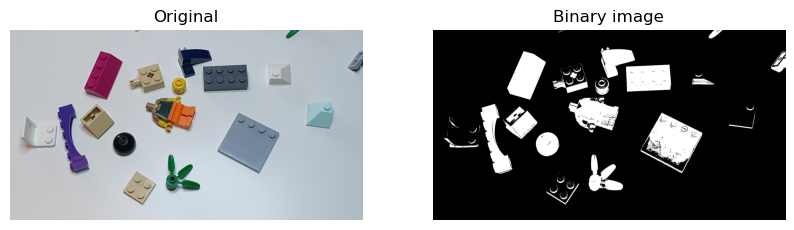

In [5]:
in_dir = "../ex5-BLOBAnalysis/data"
im_name = "/lego_4_small.png"
im_org = io.imread(in_dir + im_name)
im_gray = color.rgb2gray(im_org)
thres = threshold_otsu(im_gray)
im_bin = im_gray < thres

show_comparison(im_org, im_bin, 'Binary image')

**Exercise 2:** 

Remove border BLOBs

In [6]:
im_process = segmentation.clear_border(im_bin)

**Exercise 3:** Cleaning using morphological operations

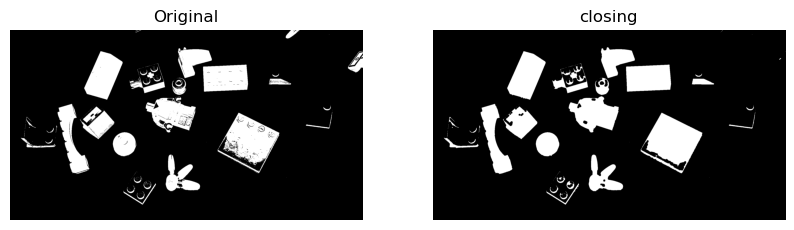

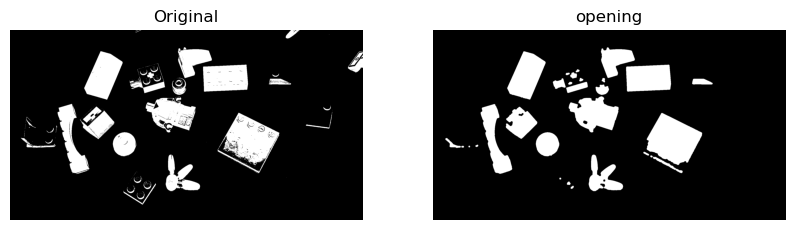

In [11]:
footprint = morphology.disk(5)
im_process = morphology.binary_closing(im_process, footprint)
im_open = morphology.binary_opening(im_process, footprint)
show_comparison(im_bin, im_process, "closing")
show_comparison(im_bin, im_open, "opening")

**Exercise 4:** 
Find labels
The actual connected component analysis / BLOB analysis is performed using measure.label :

In [12]:
label_img = measure.label(im_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 29


**Exercise 5:**

Visualize found labels
We can use the function label2rbg to create a visualization of the found BLOBS. Show this together with the original image.

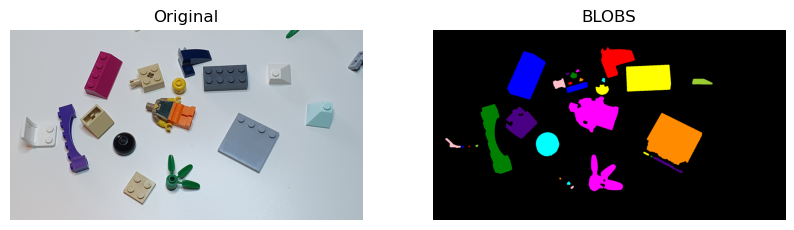

In [13]:
im_blob = label2rgb(label_img)
show_comparison(im_org, im_blob, 'BLOBS')

**Exericse 6:**

Compute BLOB features
It is possible to compute a wide variety of BLOB features using the measure.regionprops function:

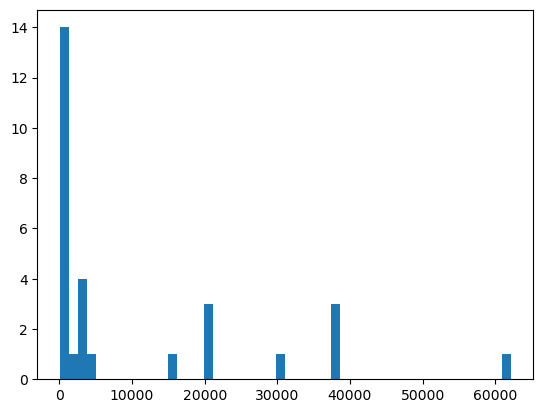

In [14]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

**Exercise 7:**

Exploring BLOB features

There is an example program called Ex5-BlobAnalysisInteractive.py in the exercise material folder.

With that program, you can explore different BLOB features interactively. It requires installation of plotly:

conda install -c plotly plotly=5.10.0


# Cell counting

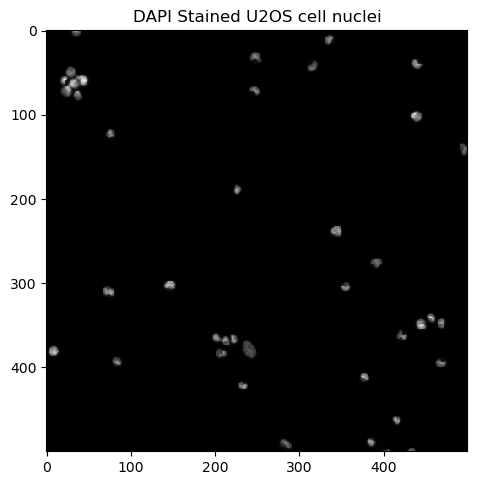

In [17]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

As can be seen we use slicing to extract a part of the image. You can use vmin and vmax to visualise specific gray scale ranges (0 to 150 in the example above). Adjust these limits to find out where the cell nuclei are most visible.

Initially, we would like to apply a threshold to create a binary image where nuclei are foreground. To select a good threshold, inspect the histogram:

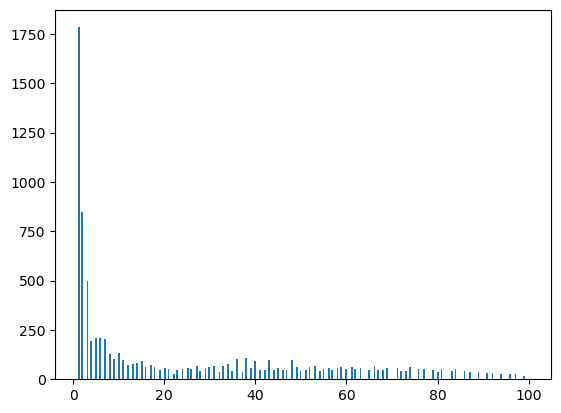

In [18]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

**Exercise 8:** Threshold selection

Select an appropriate threshold, that seperates nuclei from the background. You can set it manually or use Otsus method.

Show the binary image together with the original image and evaluate if you got the information you wanted in the binary image.

It can be seen that there is some noise (non-nuclei) present and that some nuclei are connected. Nuclei that are overlapping very much should be discarded in the analysis. However, if they are only touching each other a little we can try to separate them. More on this later.

To make the following analysis easier the objects that touches the border should be removed.

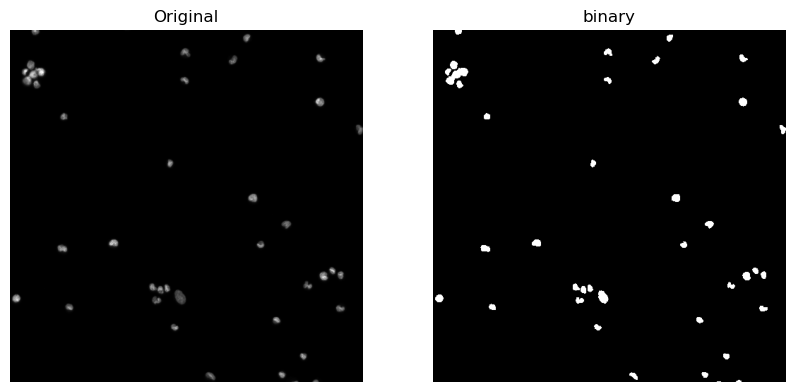

In [19]:
thres = threshold_otsu(img_gray)
img_bin = img_gray > thres
show_comparison(img_gray, img_bin, 'binary')

**Exercise 9:** 
Remove border BLOBS
Use segmentation.clear_border to remove border pixels from the binary image.

To be able to analyse the individual objects, the objects should be labelled.

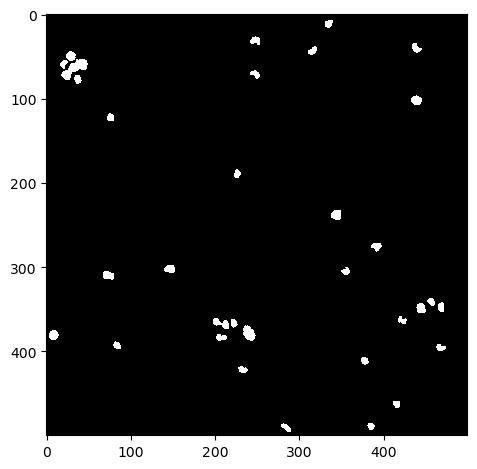

In [20]:
# quitamos los bordes para acabar con las celulas de ahi
cel_no_border = clear_border(img_bin)
io.imshow(cel_no_border, cmap="gray")

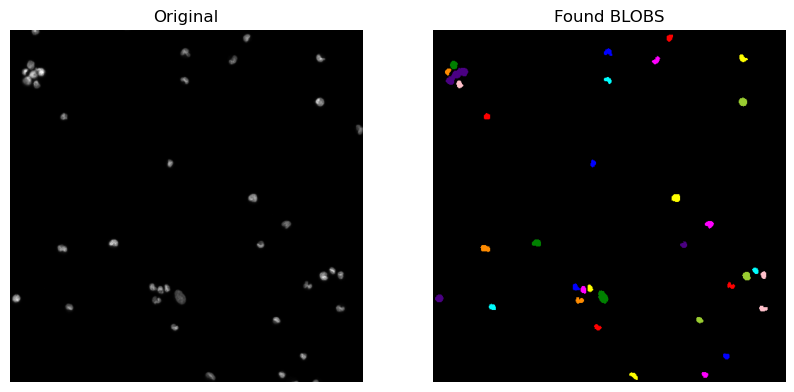

In [21]:
label_img = measure.label(cel_no_border)
image_label_overlay = label2rgb(label_img)
show_comparison(img_gray, image_label_overlay, 'Found BLOBS')

**Exercise 10: BLOB features**

The task is now to find some object features that identify the cell nuclei and let us remove noise and connected nuclei. We use the function regionprops to compute a set of features for each object:

In [22]:
region_props = measure.regionprops(label_img)

In [23]:
# For example can the area of the first object be seen by: print(region_props[0].area).
# all areas
areas = np.array([prop.area for prop in region_props])

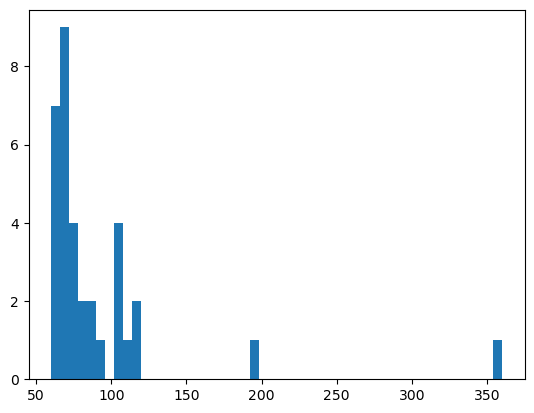

In [25]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(areas, bins=50)
plt.show()

**Exercise 11:** 
BLOB classification by area
Select a minimum and maximum allowed area and use the following to visualise the result:

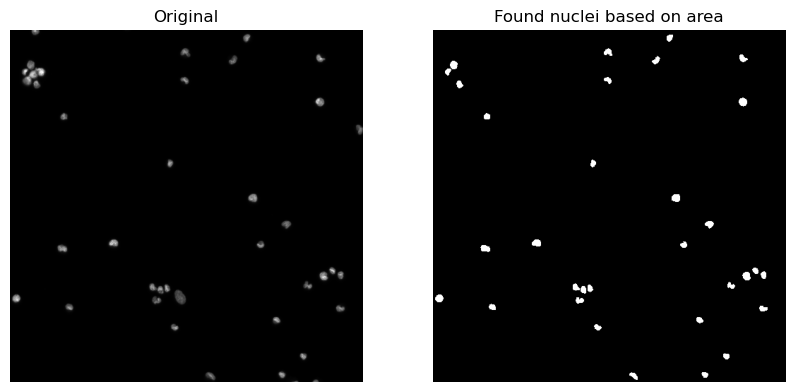

In [26]:
min_area = 10
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

**Exercise 12:** Feature space
Extract all the perimeters of the BLOBS:

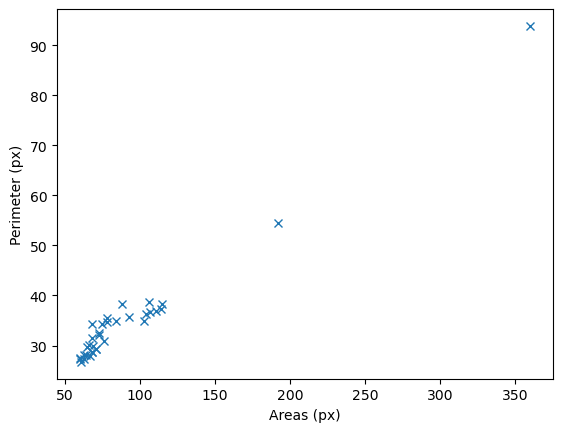

In [35]:
perimeters = np.array([prop.perimeter for prop in region_props])

fig, ax = plt.subplots(1,1)
ax.plot(areas, perimeters, 'x')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Perimeter (px)')
plt.show()

Try to plot the areas versus the perimeters.



**exercise 13**

In [36]:
def circularity(area, perimeter):
    '''
    You may get values larger than 1 because
    we are in a "discrete" (pixels) domain. Check:

    CIRCULARITY OF OBJECTS IN IMAGES, Botterma, M.J. (2000)
    https://core.ac.uk/download/pdf/14946814.pdf
    '''
    f_circ = (4*np.pi*area)/(perimeter**2)
    return f_circ

circs = circularity(areas, perimeters)

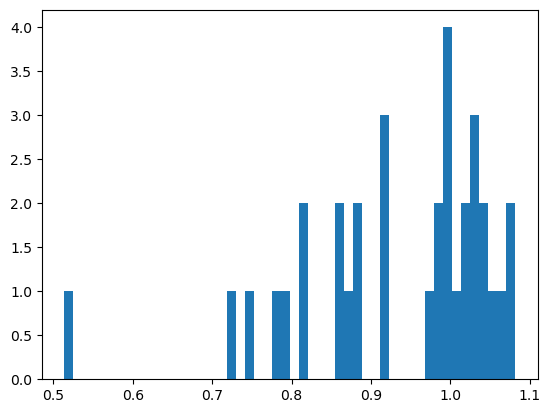

In [37]:
plt.hist(circs, bins=50)
plt.show()

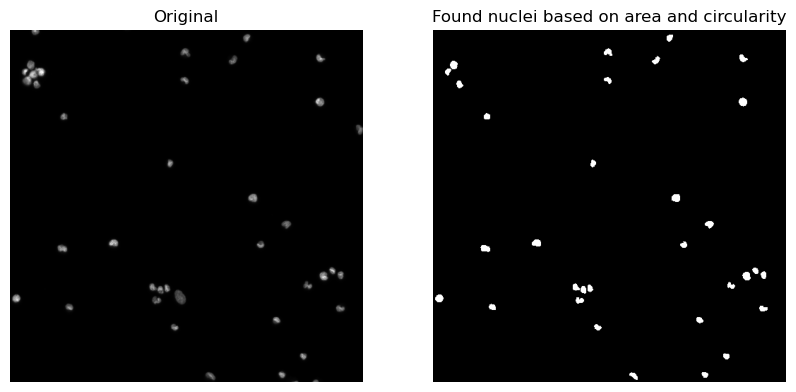

In [38]:
min_circ = 0.7
min_area = 10 
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	circ = circularity(region.area, region.perimeter)
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or circ < min_circ:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0

# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area and circularity')

**exercise 14**
BLOB circularity and area


Try to plot the areas versus the circularity. What do you observe?

Extend your method to return the number (the count) of well-formed nuclei in the image.

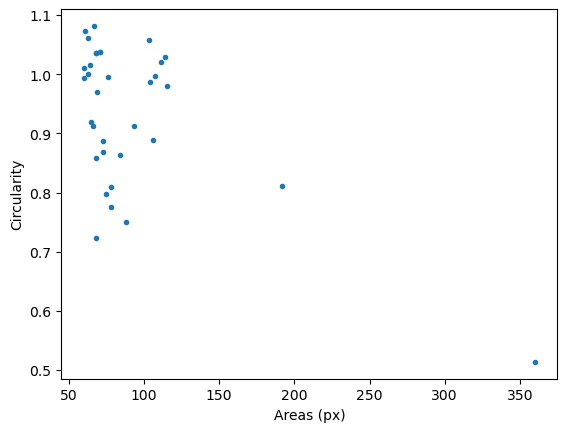

In [39]:
fig, ax = plt.subplots(1,1)
ax.plot(areas, circs, '.')
ax.set_xlabel('Areas (px)')
ax.set_ylabel('Circularity')
plt.show()

se observa que la amtoria de celulas con una circularidad buena tienen un area alrededor de 50 a 130

In [40]:
def cell_counting(img_gray, min_area = 10, max_area = 150, min_circ = 0.7):

    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = segmentation.clear_border(img_bin)

    # Label image
    label_img = measure.label(img_c_b)

    # Extract properties
    region_props = measure.regionprops(label_img)

    # Number of blobs
    n_nuclei = len(region_props)
    
    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            # set the pixels in the invalid areas to background
            n_nuclei = n_nuclei - 1
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei

**Exercise 15: large scale testing**

Try to test the method on a larger set of training images. Use slicing to select the different regions from the raw image.

In [41]:
def im2patch(im, patch_size=[256,256]):
    """
    Fancy function to rearrange an image into patches (Not important).
    
    Arguments:
        image: a 2D image, shape (r,c).
        patch size: size of extracted paches.
    Returns:
        patches: a 3D array which in every 3rd dimension has a patch associated 
    """
    
    r,c = im.shape
    s0, s1 = im.strides    
    nrows =r-patch_size[0]+1
    ncols = c-patch_size[1]+1
    shp = patch_size[0],patch_size[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(im, shape=shp, strides=strd)
    out_view = out_view[:,:,::patch_size[0],::patch_size[1]].reshape(patch_size[0],patch_size[1],-1)
    return out_view

In [42]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

Number of patches 24


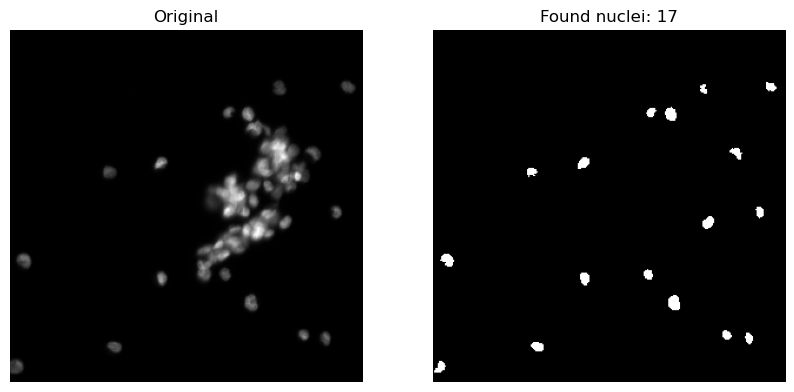

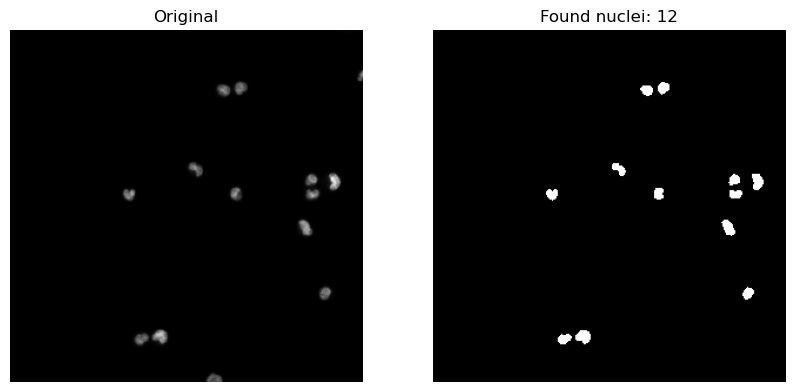

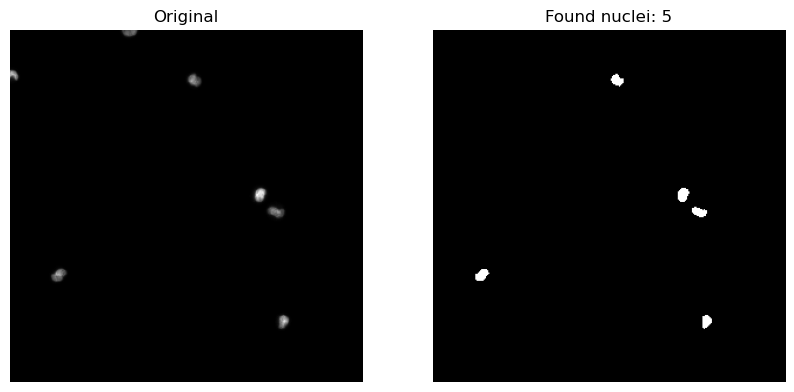

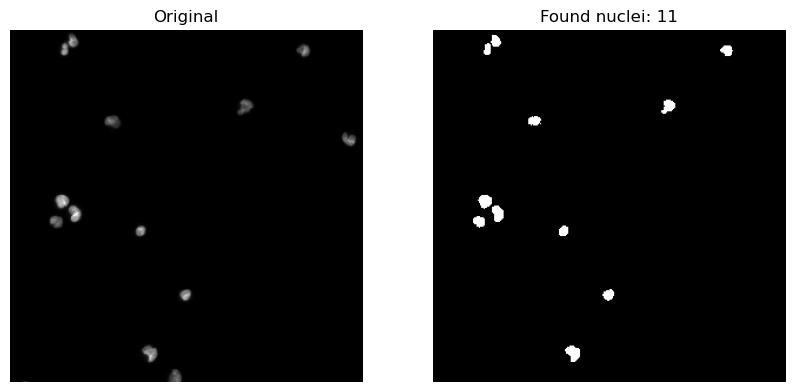

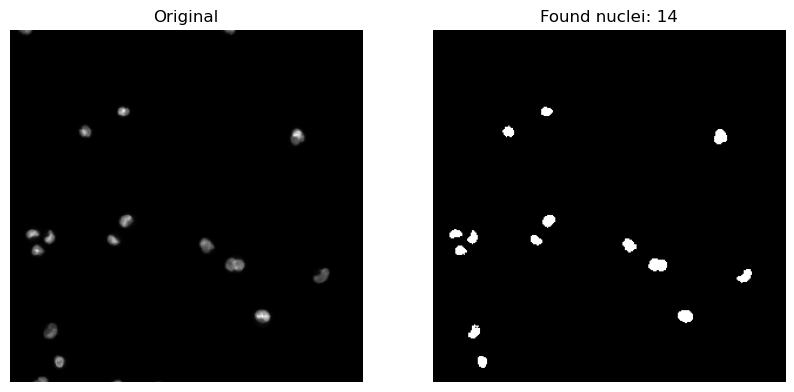

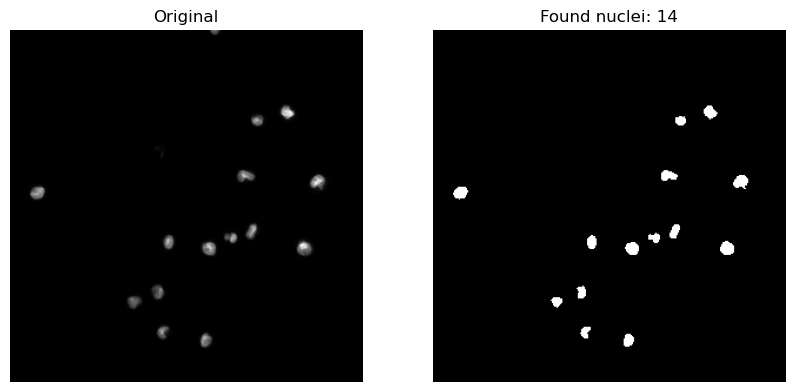

In [43]:
patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting(patch)
    show_comparison(patch, filt_label, f'Found nuclei: {n_nuclei}')

**exercise 16**

Try your method on the Sample G1 - COS7 cells DAPI channel.tiff image. COS7 cells are African Green Monkey Fibroblast-like Kidney Cells used for a variety of research purposes.

Number of patches 24


C:\Users\Usuario\AppData\Local\Temp\ipykernel_154172\2868012418.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  f_circ = (4*np.pi*area)/(perimeter**2)


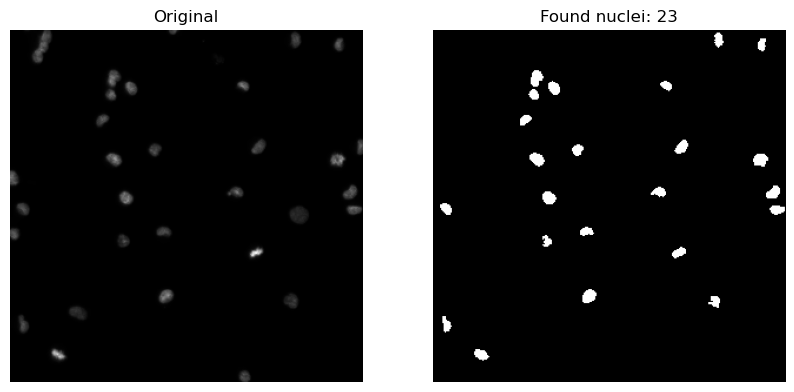

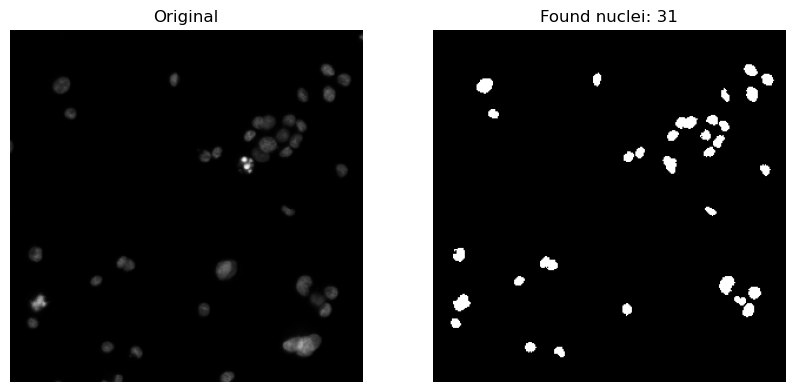

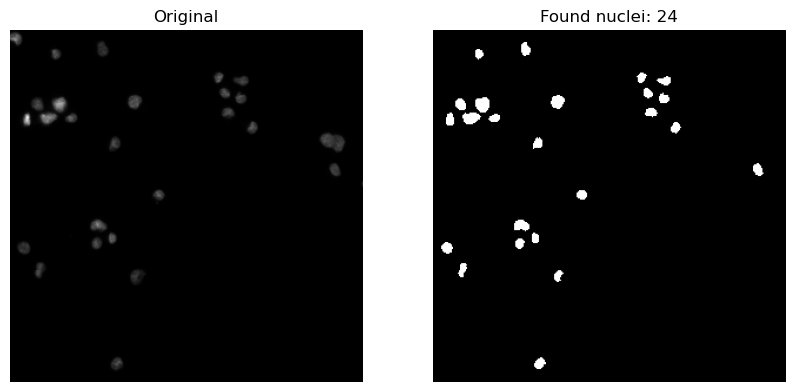

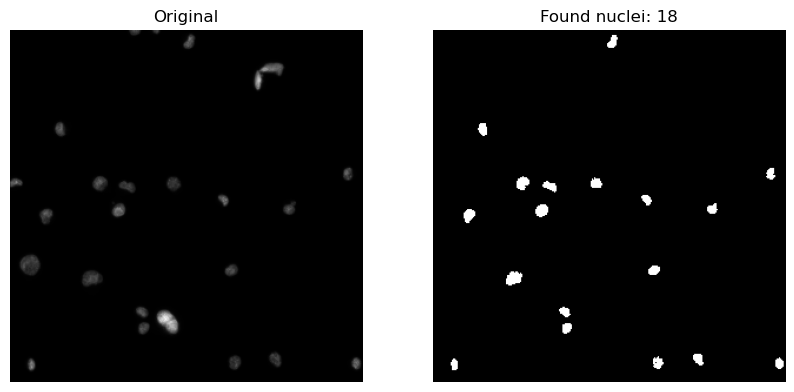

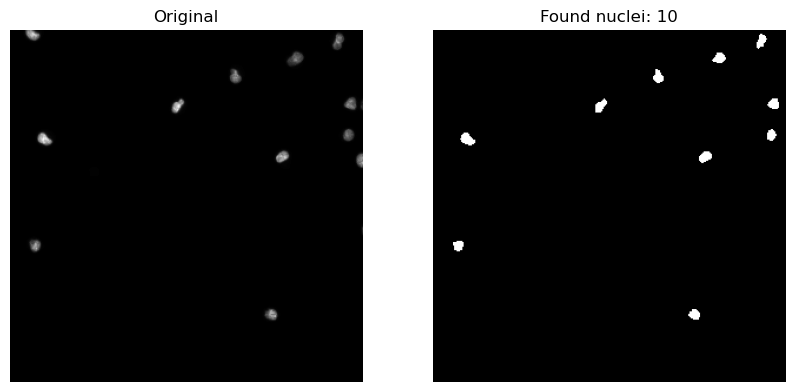

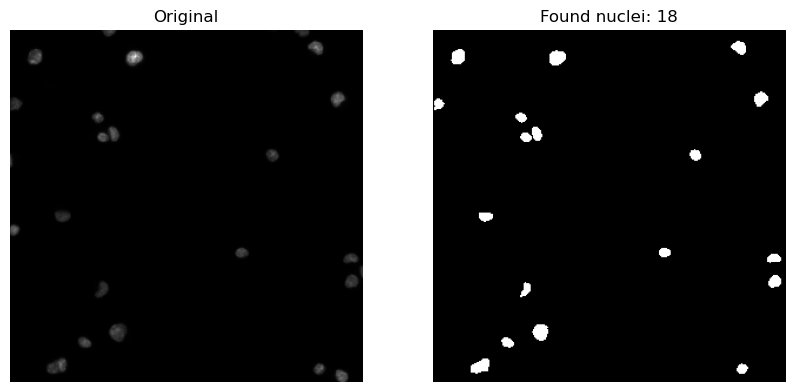

In [44]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting(patch)
    show_comparison(patch, filt_label,  f'Found nuclei: {n_nuclei}')

**Exercise 17: Handling overlap**

In certain cases cell nuclei are touching and are therefore being treated as one object. It can sometimes be solved using for example the morphological operation opening before the object labelling. The operation erosion can also be used but it changes the object area.

In [45]:
def cell_counting_ex17(img_gray, opening_sz = 5, min_area = 10, max_area = 150, min_circ = 0.7):

    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = segmentation.clear_border(img_bin)
    img_open = morphology.binary_opening(img_c_b, morphology.disk(opening_sz))

    # Label image
    label_img = measure.label(img_open)

    # Extract properties
    region_props = measure.regionprops(label_img)
    
    # Number of blobs
    n_nuclei = len(region_props)
    
    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            n_nuclei = n_nuclei - 1
            # set the pixels in the invalid areas to background
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei

Number of patches 24


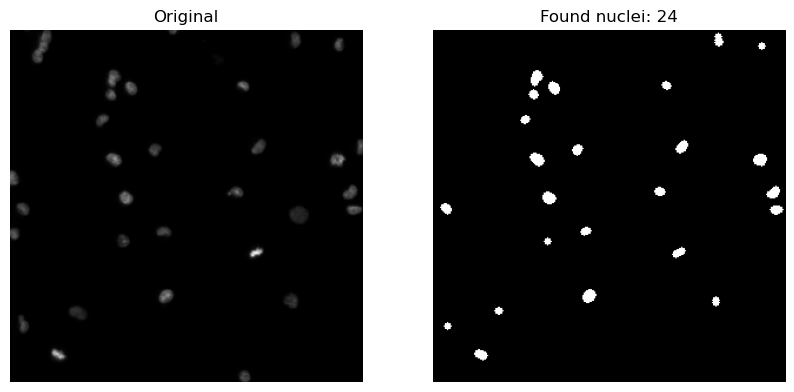

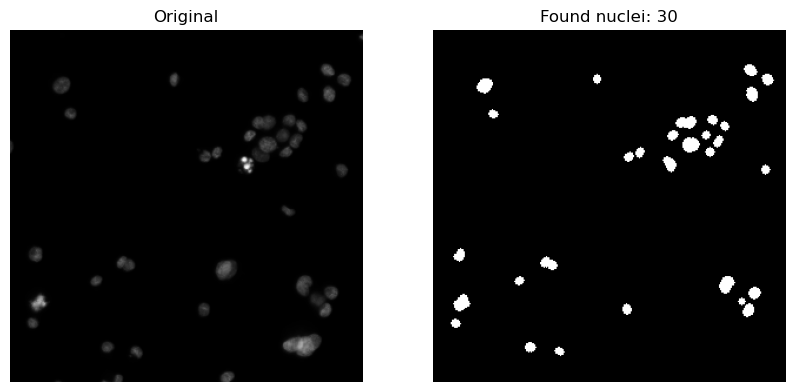

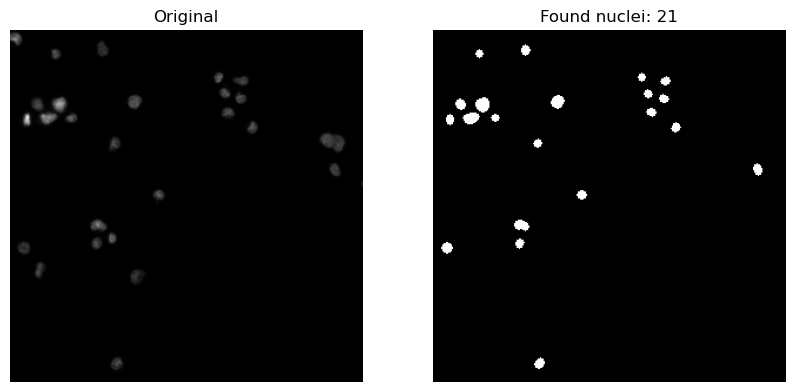

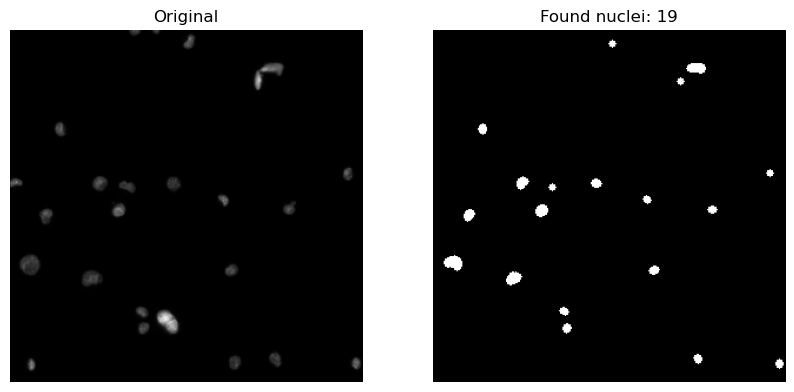

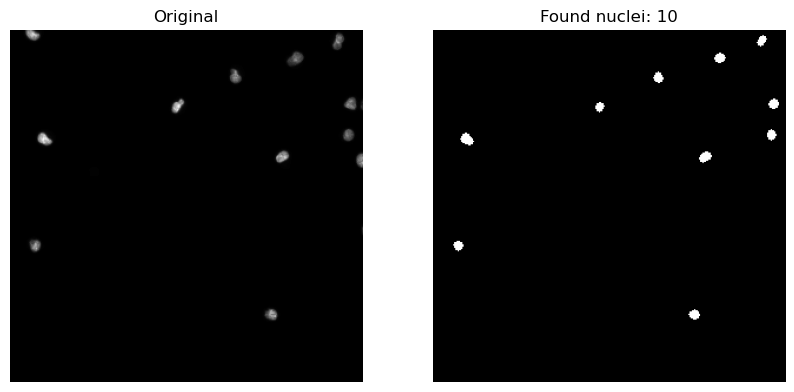

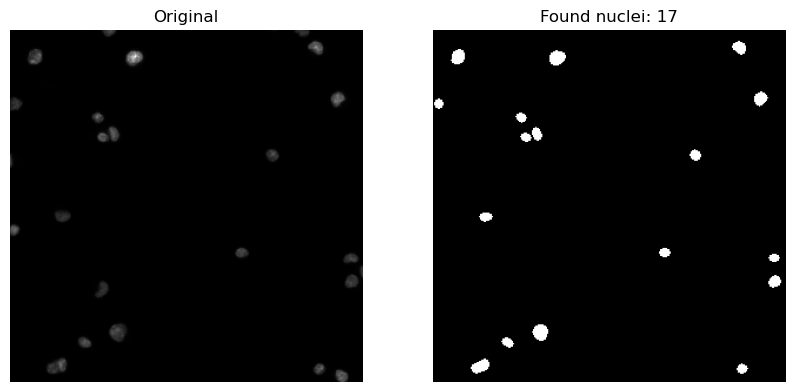

In [46]:
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
img_gray = img_as_ubyte(img_org)

patches = im2patch(img_gray, patch_size=[300,300])
print(f'Number of patches {patches.shape[-1]}')

for idx_patch in range(6):
    patch = patches[:,:,idx_patch]
    filt_label, n_nuclei = cell_counting_ex17(patch, opening_sz = 3)
    show_comparison(patch, filt_label, f'Found nuclei: {n_nuclei}')